## Interchange Intervention

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/basic_tutorials/Basic_Intervention.ipynb)

In [28]:
__author__ = "Aryaman Arora and Zhengxuan Wu"
__version__ = "10/05/2023"

### Overview

This tutorial aims to reproduce some of the results in this [notebook](https://github.com/aryamanarora/nano-causal-interventions/blob/main/The%20capital%20of%20France%20is.ipynb) for path patching or causal scrubbing. This library could potentially support other kinds of interventions that were not originally supported by previous works.

### Set-up

In [29]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

In [30]:
import pandas as pd
import pyvene
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import RepresentationConfig, IntervenableConfig, IntervenableModel
from pyvene import VanillaIntervention

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

### Factual recall

In [31]:
config, tokenizer, gpt = pyvene.create_gpt2()

base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [tokenizer(base, return_tensors="pt"), tokenizer(source, return_tensors="pt")]
print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
print(source)
res = gpt(**inputs[1])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
The capital of Spain is
_Madrid              0.10501258075237274
_the                 0.09496944397687912
_Barcelona           0.07027709484100342
_a                   0.04010076820850372
_now                 0.028243059292435646
_in                  0.027599968016147614
_Spain               0.02299264818429947
_Catalonia           0.0188234094530344
_also                0.018688470125198364
_not                 0.01735655590891838

The capital of Italy is
_Rome                0.15735071897506714
_the                 0.07316315919160843
_Milan               0.04687758535146713
_a                   0.03449976444244385
_now                 0.03200336545705795
_in                  0.023065762594342232
_also                0.02274804189801216
_home                0.019202742725610733
_not                 0.016405189409852028
_Italy               0.015771420672535896


### Patch Patching on Position-aligned Tokens
We path patch on two modules on each layer:
- [1] MLP output (the MLP output will be from another example)
- [2] MHA input (the self-attention module input will be from another module)

In [32]:
def simple_position_config(model_type, component, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                component,          # component
                "pos",              # intervention unit
                1,                  # max number of unit
            ),
        ],
        intervention_types=VanillaIntervention,
    )
    return config


base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt")]

In [34]:
gpt

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [25]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode(" Madrid Rome")

data = []
for layer_i in range(gpt.config.n_layer):
    config = simple_position_config(type(gpt), "mlp_output", layer_i)
    intervenable = IntervenableModel(config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": pos_i}
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"f{layer_i}",
                    "pos": pos_i,
                    "type": "mlp_output",
                }
            )

    config = simple_position_config(type(gpt), "attention_input", layer_i)
    intervenable = IntervenableModel(config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": pos_i}
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"a{layer_i}",
                    "pos": pos_i,
                    "type": "attention_input",
                }
            )
df = pd.DataFrame(data)

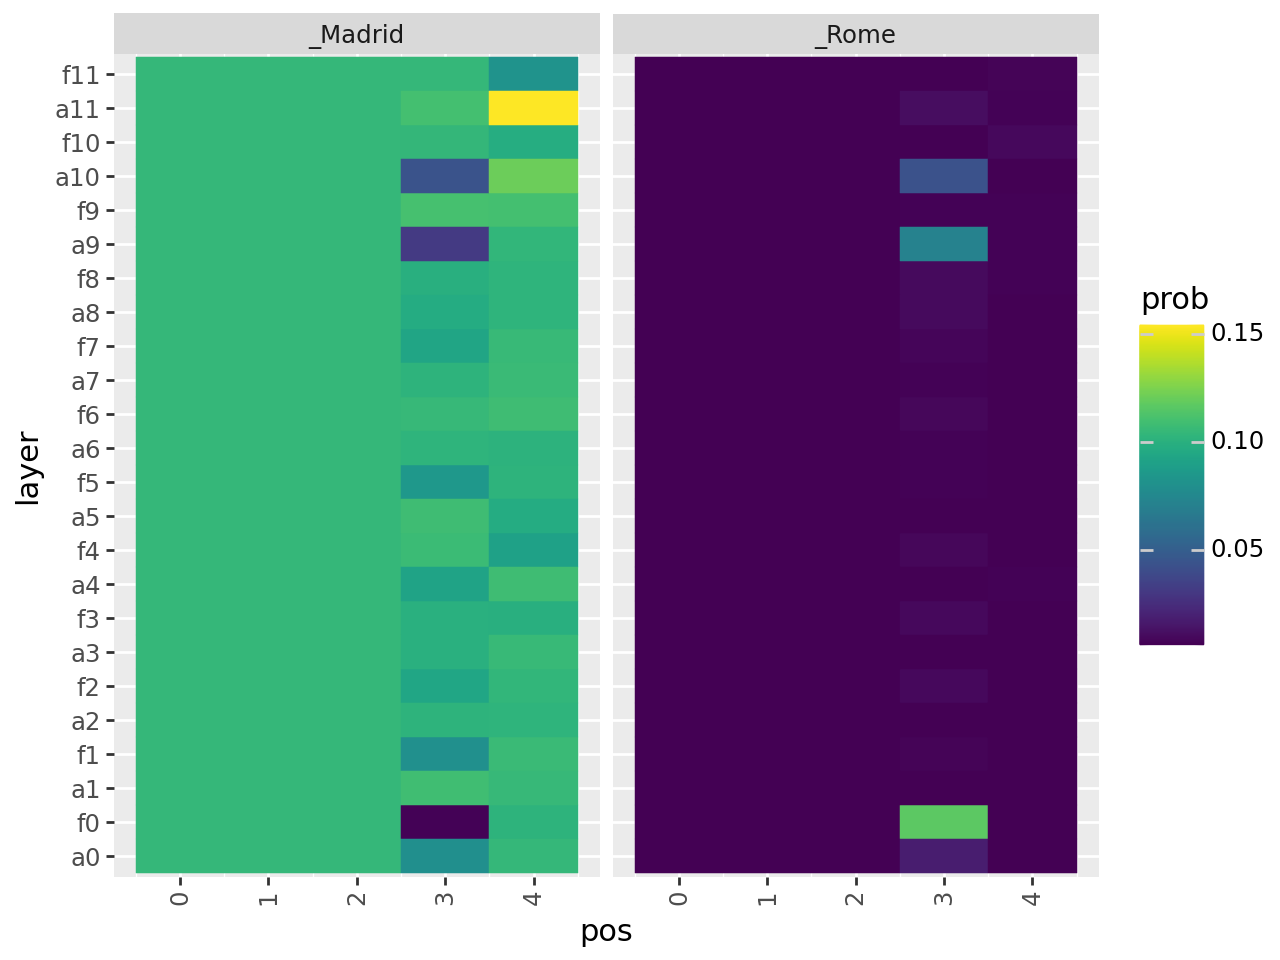

In [26]:
df["layer"] = df["layer"].astype("category")
df["token"] = df["token"].astype("category")
nodes = []
for l in range(gpt.config.n_layer - 1, -1, -1):
    nodes.append(f"f{l}")
    nodes.append(f"a{l}")
df["layer"] = pd.Categorical(df["layer"], categories=nodes[::-1], ordered=True)

g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="prob", color="prob"))
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90))
)
display(g)

/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/lukasz/miniconda3/envs/nlp/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


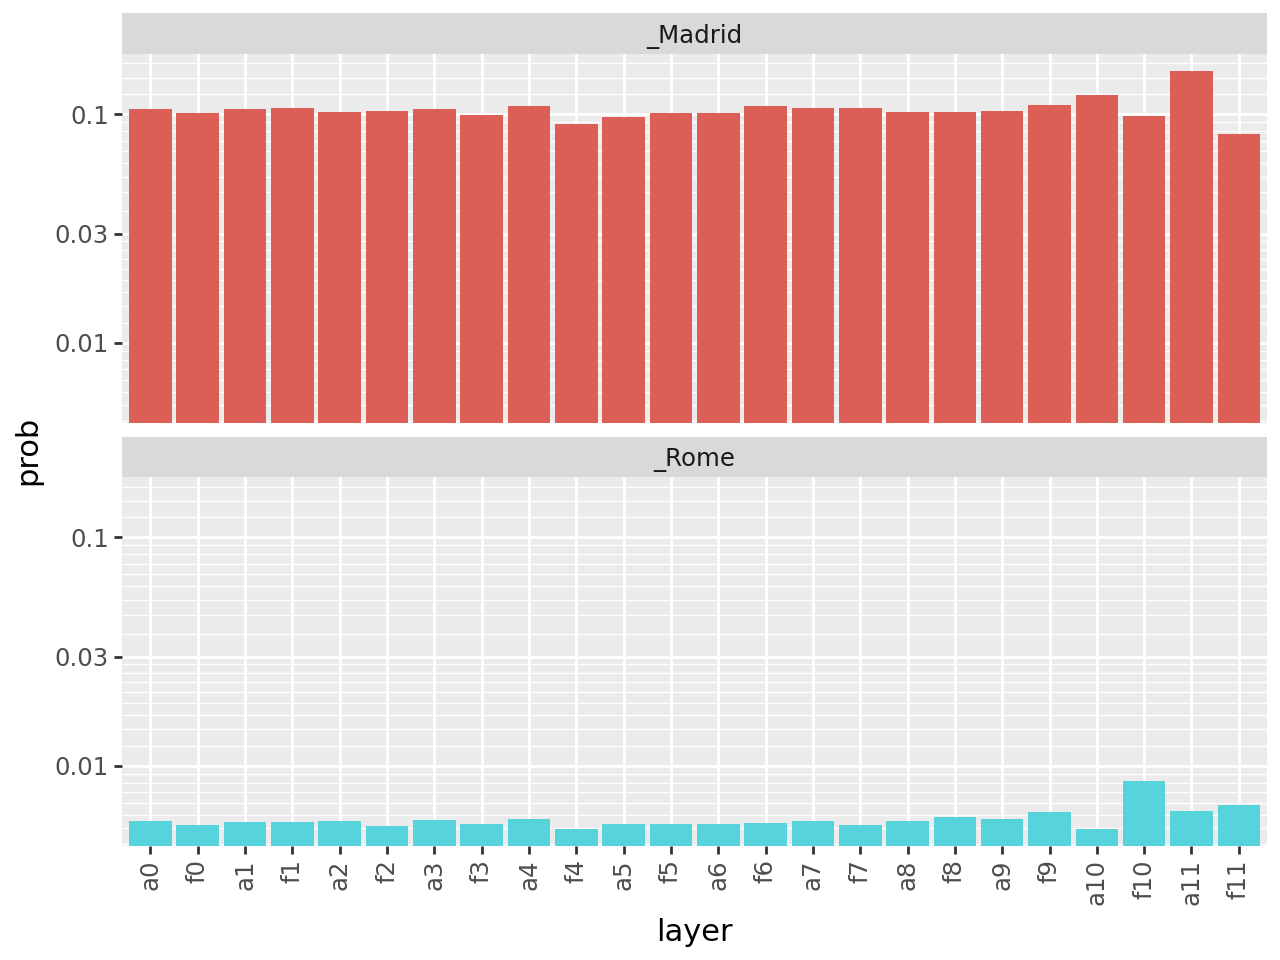

In [27]:
filtered = df
filtered = filtered[filtered["pos"] == 4]
g = (
    ggplot(filtered)
    + geom_bar(aes(x="layer", y="prob", fill="token"), stat="identity")
    + theme(axis_text_x=element_text(rotation=90), legend_position="none")
    + scale_y_log10()
    + facet_wrap("~token", ncol=1)
)
display(g)